In [64]:
import numpy as np
from scipy.io import wavfile
import os
from tqdm.notebook import tqdm
import librosa
from pathlib import Path
import matplotlib.pyplot as plt
import IPython.display as ipd
import glob
import soundfile as sf

## 1. 함수 설정

In [67]:
## 파일 읽어오기
def load_audio(file_path, sr=16000):
    """
       file_path : 파일위치
       sr : 오디오를 읽을 때 Sampling rate 지정
    """
    ## 확장자 추출
    ext = Path(file_path).suffix
    
    ## 파일 읽기
    if ext in ['.wav', '.flac']:
        wav, sr = librosa.load(file_path, sr=sr)
    elif ext == '.pcm':
        wav = np.memmap(file_path, dtype='h', mode='r').astype('float32') / 32767
    elif ext in ['.raw', '.RAW']:
        wav, sr = sf.read(file_path, channels=1, samlerate=sr, format='RAW', subtype='PCM_16')
    else:
        raise ValueError("Unsupported preprocess method : {0}".format(ext))
        
    return wav, sr

## 공백 자르기(패딩 추가)
def trim_audio(wav, top_db=10, pad_len=4000):
    """
    
    """
    ## 최대 db에 따라 음성의 자를 위치 판별
    non_silence_indices = librosa.effects.split(wav, top_db=top_db)
    start = non_silence_indices[0][0]
    end = non_silence_indices[-1][1]
    
    ## 음성 자르기
    wav = wav[start:end]
    
    ## padding 추가
    wav = np.hstack([np.zeros(pad_len), wav, np.zeros(pad_len)])
    
    return wav

## WAV 그려보기
def plot_wav(wav, sr):
    ## 그려보기
    plt.figure(1)

    plot_a = plt.subplot(211)
    plot_a.plot(wav)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(wav, NFFT=1024, Fs=sr, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

    plt.show()

## 2. 샘플

In [68]:
## Wav 파일 읽어오기  pcm 또는 다른 확장자도 사용 가능.
root_path = '잡음제거'
file_list = glob.glob(os.path.join(root_path, "*.wav"))
#file_list = glob.glob(os.path.join(root_path, "*.pcm"))

In [69]:
## 파일 불러오기(타코트론2는 기본적으로 16000 sampling rate에서 동작하므로 16000 sampling rate에서 작업.)
wav, sr = load_audio(file_list[0])
ipd.Audio(wav, rate=sr)

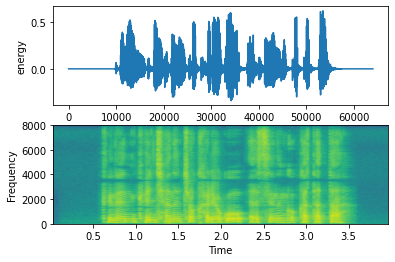

In [70]:
plot_wav(wav, sr)

In [71]:
## 오디오 자르기
trimed_wav= trim_audio(wav, top_db=10)
ipd.Audio(trimed_wav, rate=sr)

C:\Users\dsbak\Anaconda3\envs\voice-py36\lib\site-packages\matplotlib\axes\_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


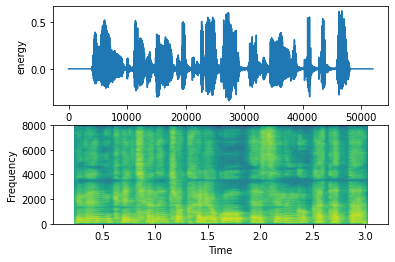

In [72]:
plot_wav(trimed_wav, sr)

## 3. 전체 전처리

In [73]:
## 타코트론2는 기본적으로 16000 sampling rate에서 동작하므로 16000 sampling rate에서 작업
sampling_rate = 16000

## 환경에 따라 소리 크기를 변경하여 앞 뒤의 음성을 제거할 수 있도록 설정
decibel=10

In [74]:
## Wav 파일 읽어오기  pcm 또는 다른 확장자도 사용 가능.
root_path = '잡음제거'
file_list = glob.glob(os.path.join(root_path, "*.wav"))
#file_list = glob.glob(os.path.join(root_path, "*.pcm"))

In [75]:
## 저장할 위치 선택
save_path = 'temp'
os.makedirs(save_path, exist_ok=True)

In [76]:
for file_path in tqdm(file_list):
    
    ## 파일 불러오기(타코트론2는 기본적으로 16000 sampling rate에서 동작하므로 16000 sampling rate에서 작업.)
    wav, sr = load_audio(file_path, sr=sampling_rate)
    
    ## 오디오 자르기(패딩 추가)
    trimed_wav= trim_audio(wav, top_db=decibel)
    
    filename=Path(file_path).name
    temp_save_path = os.path.join(save_path, filename)
    
    ## 저장하기
    sf.write(temp_save_path, trimed_wav, sampling_rate)